In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, algebra
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import itertools
import time

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


In [16]:
def mp_resPois2(MP, uh, f=0., a=1., M=(0.,0.), neu_data={}, **kwargs):
    if isinstance(a,(int,float)):
        a={d:a for d in MP.mesh.domains}
    if isinstance(f,(int,float)):
        f={d:f for d in MP.mesh.domains}
        
    n = MP.mesh.numpatches
    indicator = np.zeros(MP.Z_ofs[-1])
    uh_loc = MP.Basis@uh
    uh_per_patch = dict()
    
    #residual contribution, TODO vectorize
    t=time.time()
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        h = np.linalg.norm([(b-a)*kv.meshsize_max()/(kv.support()[1]-kv.support()[0]) for (a,b),kv in zip(geo.bounding_box(),kvs)])
        uh_per_patch[p] = uh_loc[np.arange(MP.N[p]) + MP.N_ofs[p]]   #cache Spline Function on patch p
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        u_func = geometry.BSplineFunc(kvs, uh_per_patch[p]) 
        
        R=h**2*assemble.assemble('(f + div(a*grad(uh)))**2 * v * dx', kvs0, geo=geo, a=a[MP.mesh.patch_domains[p]],f=f[MP.mesh.patch_domains[p]],uh=u_func, M=M[MP.mesh.patch_domains[p]],**kwargs)
        indicator[MP.Z_ofs[p]:MP.Z_ofs[p+1]] = R.ravel()
    print('residual contributions took ' + str(time.time()-t) + ' seconds.')
    
    #flux contribution
    t=time.time()
    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = [assemble.int_to_bdspec(b1)], [assemble.int_to_bdspec(b2)]
        bkv1, bkv2 = assemble.boundary_kv(kvs1, bdspec1), assemble.boundary_kv(kvs2, bdspec2)
        geo = geo2.boundary(bdspec2)
        kv0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in bkv2])
        h = np.sum(assemble.assemble('v * ds', kv0, geo=geo))*kv0[0].meshsize_max()/(kv0[0].support()[1]-kv0[0].support()[0])
        uh1_grad = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        uh2_grad = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        J = assemble.assemble('((inner((a1 * uh1_grad + Ma1) - (a2 * uh2_grad + Ma2), n) )**2 * v ) * ds', kv0 ,geo=geo,a1=a[MP.mesh.patch_domains[p1]],a2=a[MP.mesh.patch_domains[p2]],uh1_grad=uh1_grad,uh2_grad=uh2_grad,M1=M[MP.mesh.patch_domains[p1]],M2=M[MP.mesh.patch_domains[p2]],**kwargs)
        supp1, supp2 = geo1.boundary(bdspec1).support(), geo2.boundary(bdspec2).support()
        indicator[p2] += 0.5 * h * J
        indicator[p2] += 0.5 * h * J
        
    # for bd in neu_data:
    #     g = neu_data[bd]
    #     for (p,b) in MP.mesh.outer_boundaries[bd]:
    #         ((kvs, geo), _) = MP.mesh.patches[p]
    #         bdspec = [assemble.int_to_bdspec(b)]
    #         bkv = assemble.boundary_kv(kvs, bdspec)
    #         geo_b = geo.boundary(bdspec)
    #         uh_grad = geometry.BSplineFunc(kvs, uh_per_patch[p]).transformed_jacobian(geo).boundary(bdspec)
    #         J = np.sum(assemble.assemble('(inner(a * uh_grad, n) - g)**2 * v * ds', kv0 ,geo=geo_b, a=a[MP.mesh.patch_domains[p]], uh_grad=uh_grad, **kwargs))
    #         indicator[p] += h * J
    # print('jump contributions took ' + str(time.time()-t) + ' seconds.')
    return np.sqrt(indicator)

In [48]:
kvs=5*[2*(bspline.make_knots(2,0.0,1.0,20),)]
geos=geometry.mp_disk()
M = topology.PatchMesh(list(zip(kvs,geos)))
MP = assemble.Multipatch(M, automatch=True)

Basis setup took 0.005488872528076172 seconds


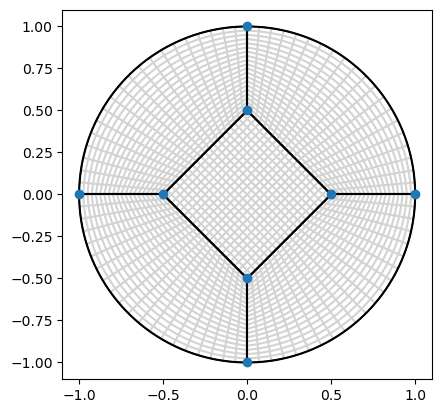

In [49]:
M.draw(knots=1, nodes=1)

In [50]:
u_ = MP.L2projection(u=lambda x,y: x**2+y**2)

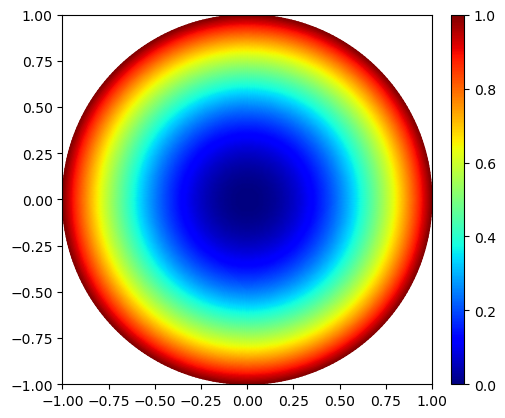

In [51]:
MP.plot(u_)

In [52]:
np.linalg.norm(mp_resPois2(MP, u_, f=-4.))

residual contributions took 0.08103108406066895 seconds.


0.00017431783948573375

In [10]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]

kvs=[(bspline.make_knots(1,0.0,1.0,xN),bspline.make_knots(1,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      geometry.Quad(np.array([[0.,2.,1.,2.],
                              [1.,1.,2.,2.]])),
      geometry.Quad(np.array([[2.,3.,2.,3.5],
                              [1.,1.,2.,2.5]])),
      geometry.Quad(np.array([[2.,3.,3.,3.5],
                              [1.,0.,1.,0.5]])),
      geometry.Quad(np.array([[2.,2.5,2.,3.],
                              [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
M=topology.PatchMesh(patches)
M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

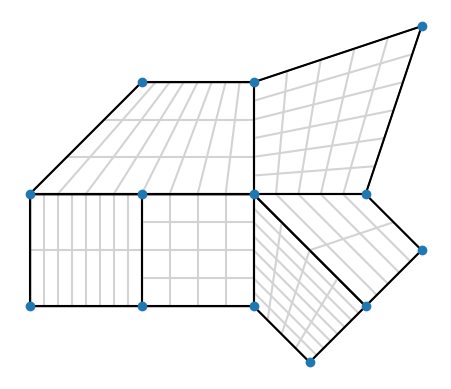

In [18]:
M.draw(knots=1, patch_idx=0, nodes=1, axis='off')
axis('scaled');

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)